# **Analyze Vrij**

Analysis of EBs pharmacologically induced from Vrij. I use object contains concatenated standard and EBs.

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from collections import defaultdict
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white', fontsize=12)

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


**Read the object**

In [3]:
adata = ad.read_h5ad('Objects/object_1_Deng_filtered_1_2_Chen_filtered_1_3_Mohammed_filtered_1_4_Nowo_filtered_1_4bis_Nowo_filtered_1_5_Posfai_filtered_1_6_Arg_filtered_1_7_Vrij_filtered_1.h5ad')

**Normalize data**

In [4]:
# Data normalization
sc.pp.normalize_total(adata, target_sum=1e4)

# Log on datas
sc.pp.log1p(adata)

# Stock data logs 
adata.raw = adata

# Scale the data
sc.pp.scale(adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


**Highly variable genes**

In [5]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


**Run PCA**

computing PCA
    with n_comps=50
    finished (0:00:00)


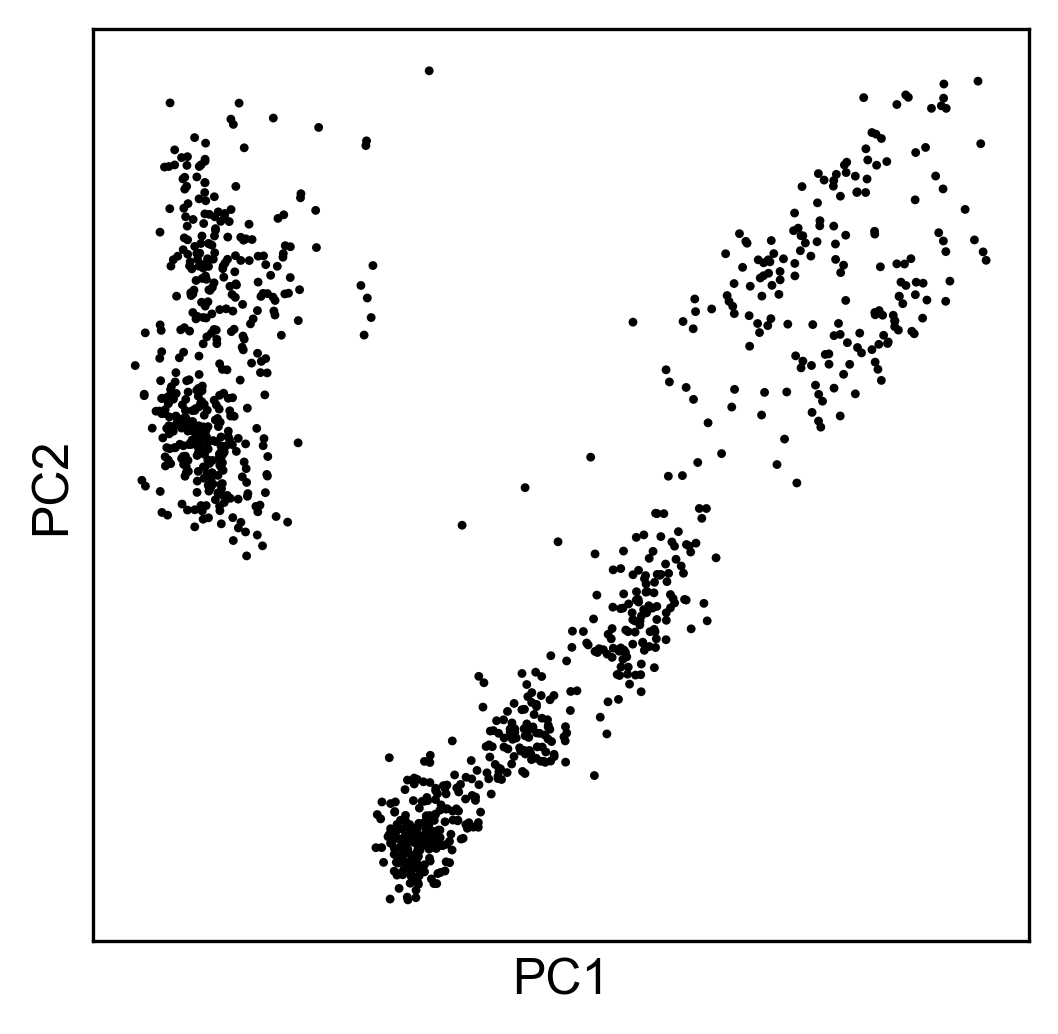

In [6]:
sc.tl.pca(adata)

# PCA plot
sc.pl.pca(adata, size=18, na_color = 'black')

**Elbow plot**

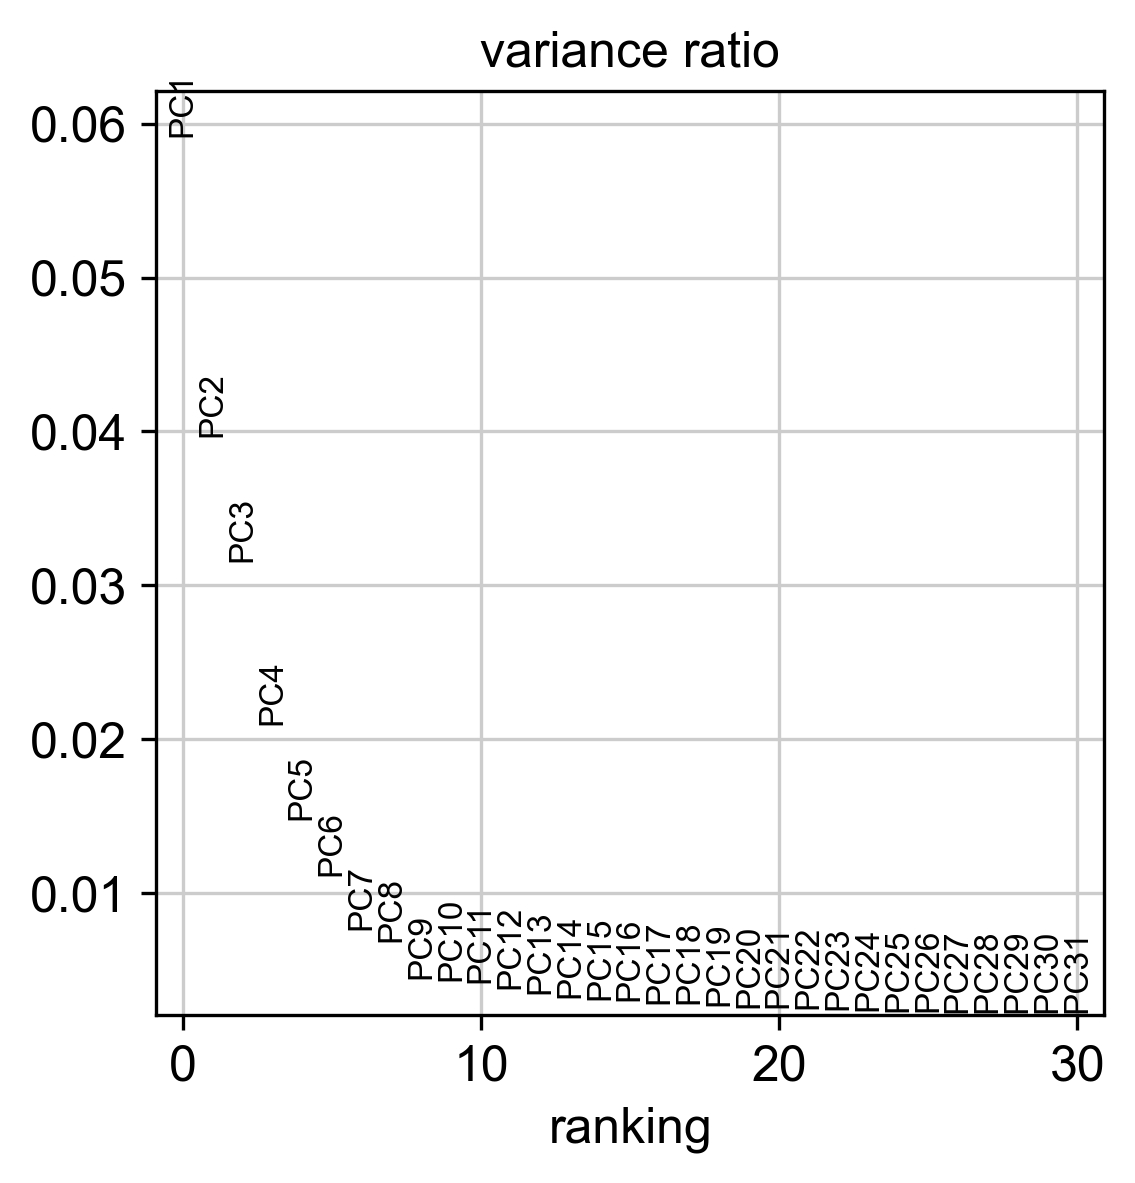

In [7]:
sc.pl.pca_variance_ratio(adata)

**Run Harmony** on the standard

In [8]:
sc.external.pp.harmony_integrate(adata, 'dataset', theta = 1, max_iter_harmony = 10, nclust = 4)

# Save new PCA
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

2024-07-09 12:03:18,166 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
C:\Users\learogue\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
2024-07-09 12:03:19,872 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-09 12:03:19,882 - harmonypy - INFO - Iteration 1 of 10
2024-07-09 12:03:19,993 - harmonypy - INFO - Iteration 2 of 10
2024-07-09 12:03:20,063 - harmonypy - INFO - Converged after 2 iterations


**Find neighbors**

In [9]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


**Make groups**

In [10]:
sc.tl.louvain(adata, resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


**Run UMAP**

In [11]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


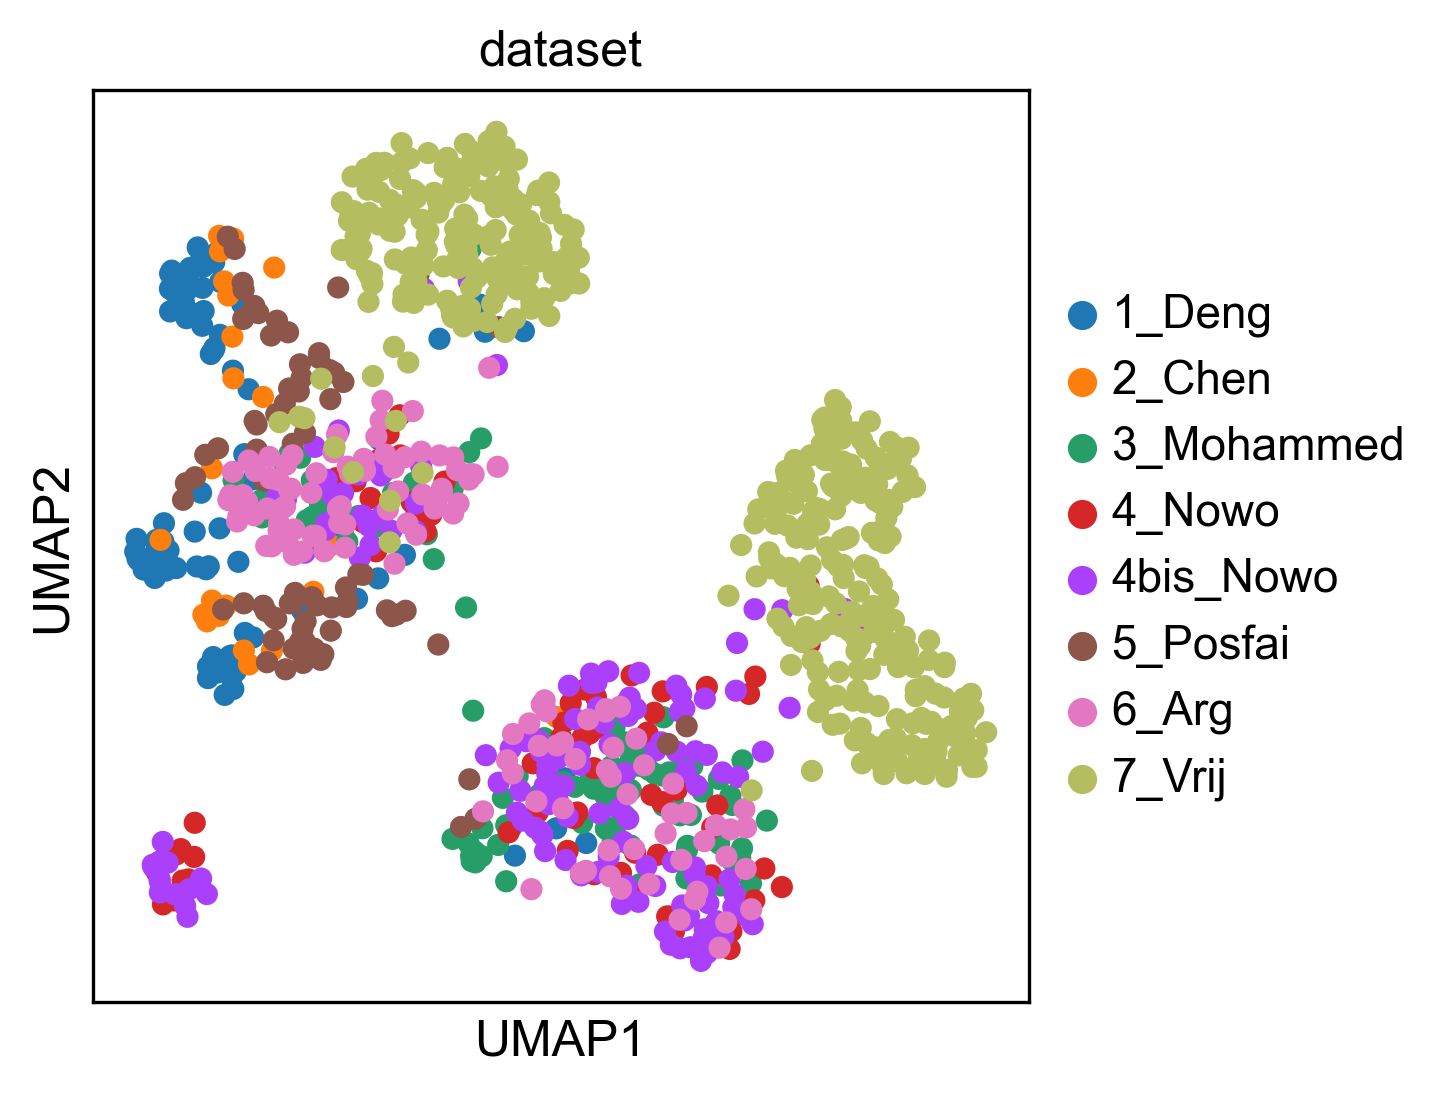

In [12]:
sc.pl.umap(adata, color=['dataset'])

We see that Vrij dataset don't group with standard but I try others parameters and don't succes to have a better UMAP.

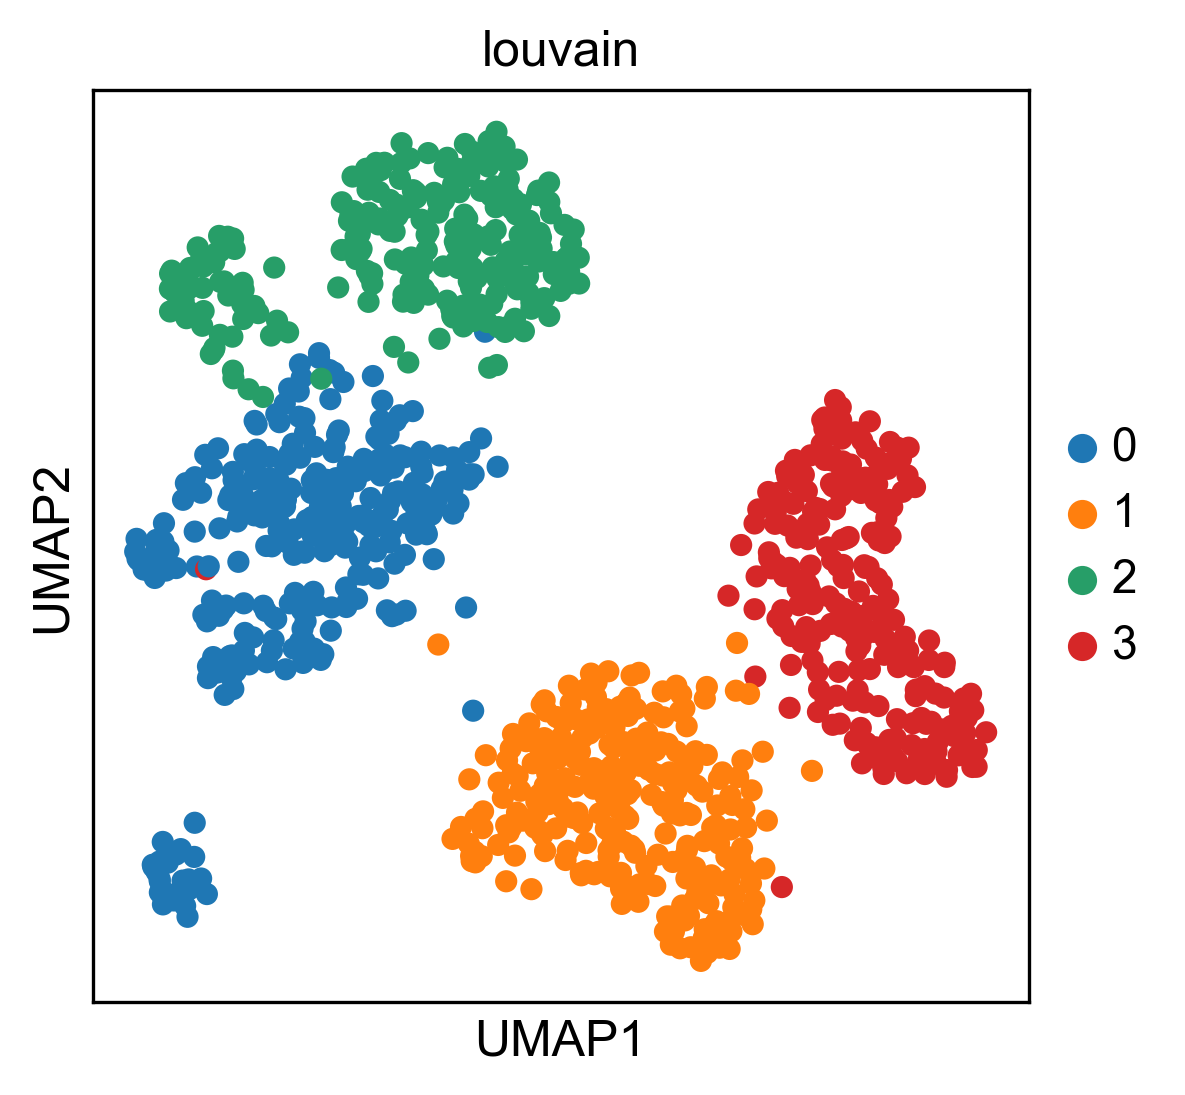

In [13]:
sc.pl.umap(adata, color=['louvain'])

**UMAPs with PrE and PE markers**

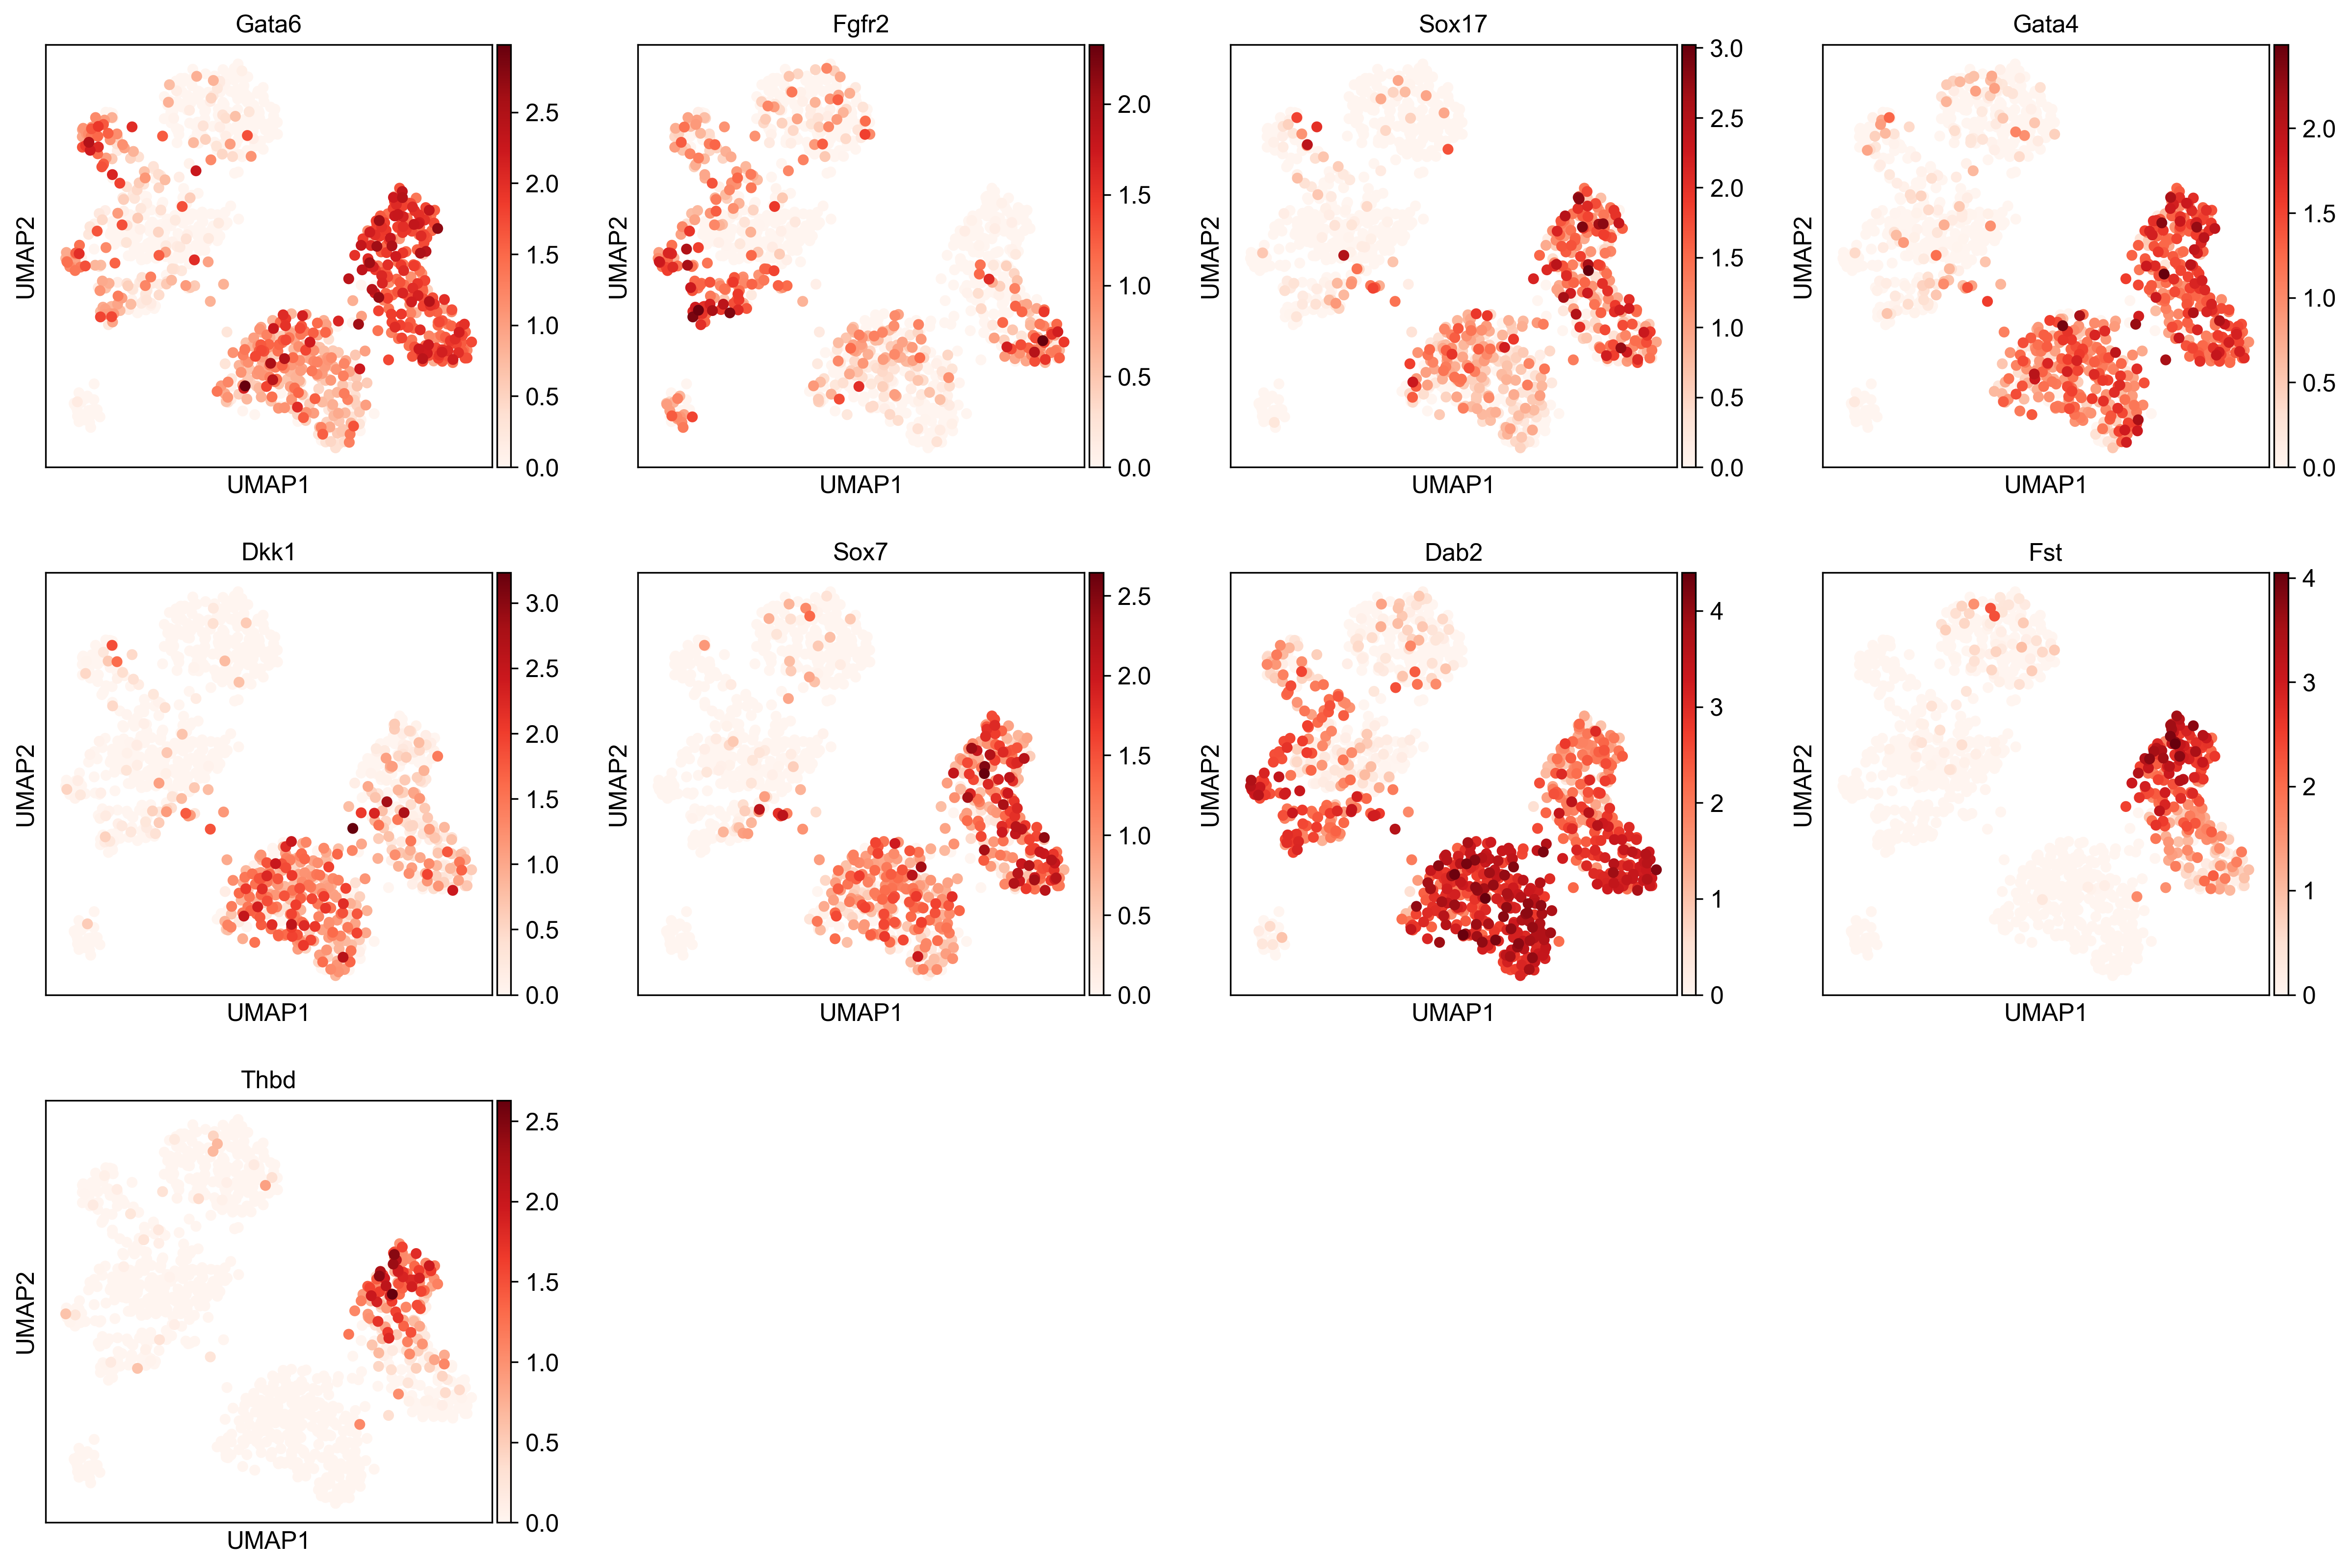

In [14]:
sc.pl.umap(adata, color=['Gata6', 'Fgfr2', 'Sox17', 'Gata4', 'Dkk1', 'Sox7', 'Dab2', 'Fst', 'Thbd'], legend_loc='on data', color_map=mpl.cm.Reds)

**UMAPs with Epi markers**

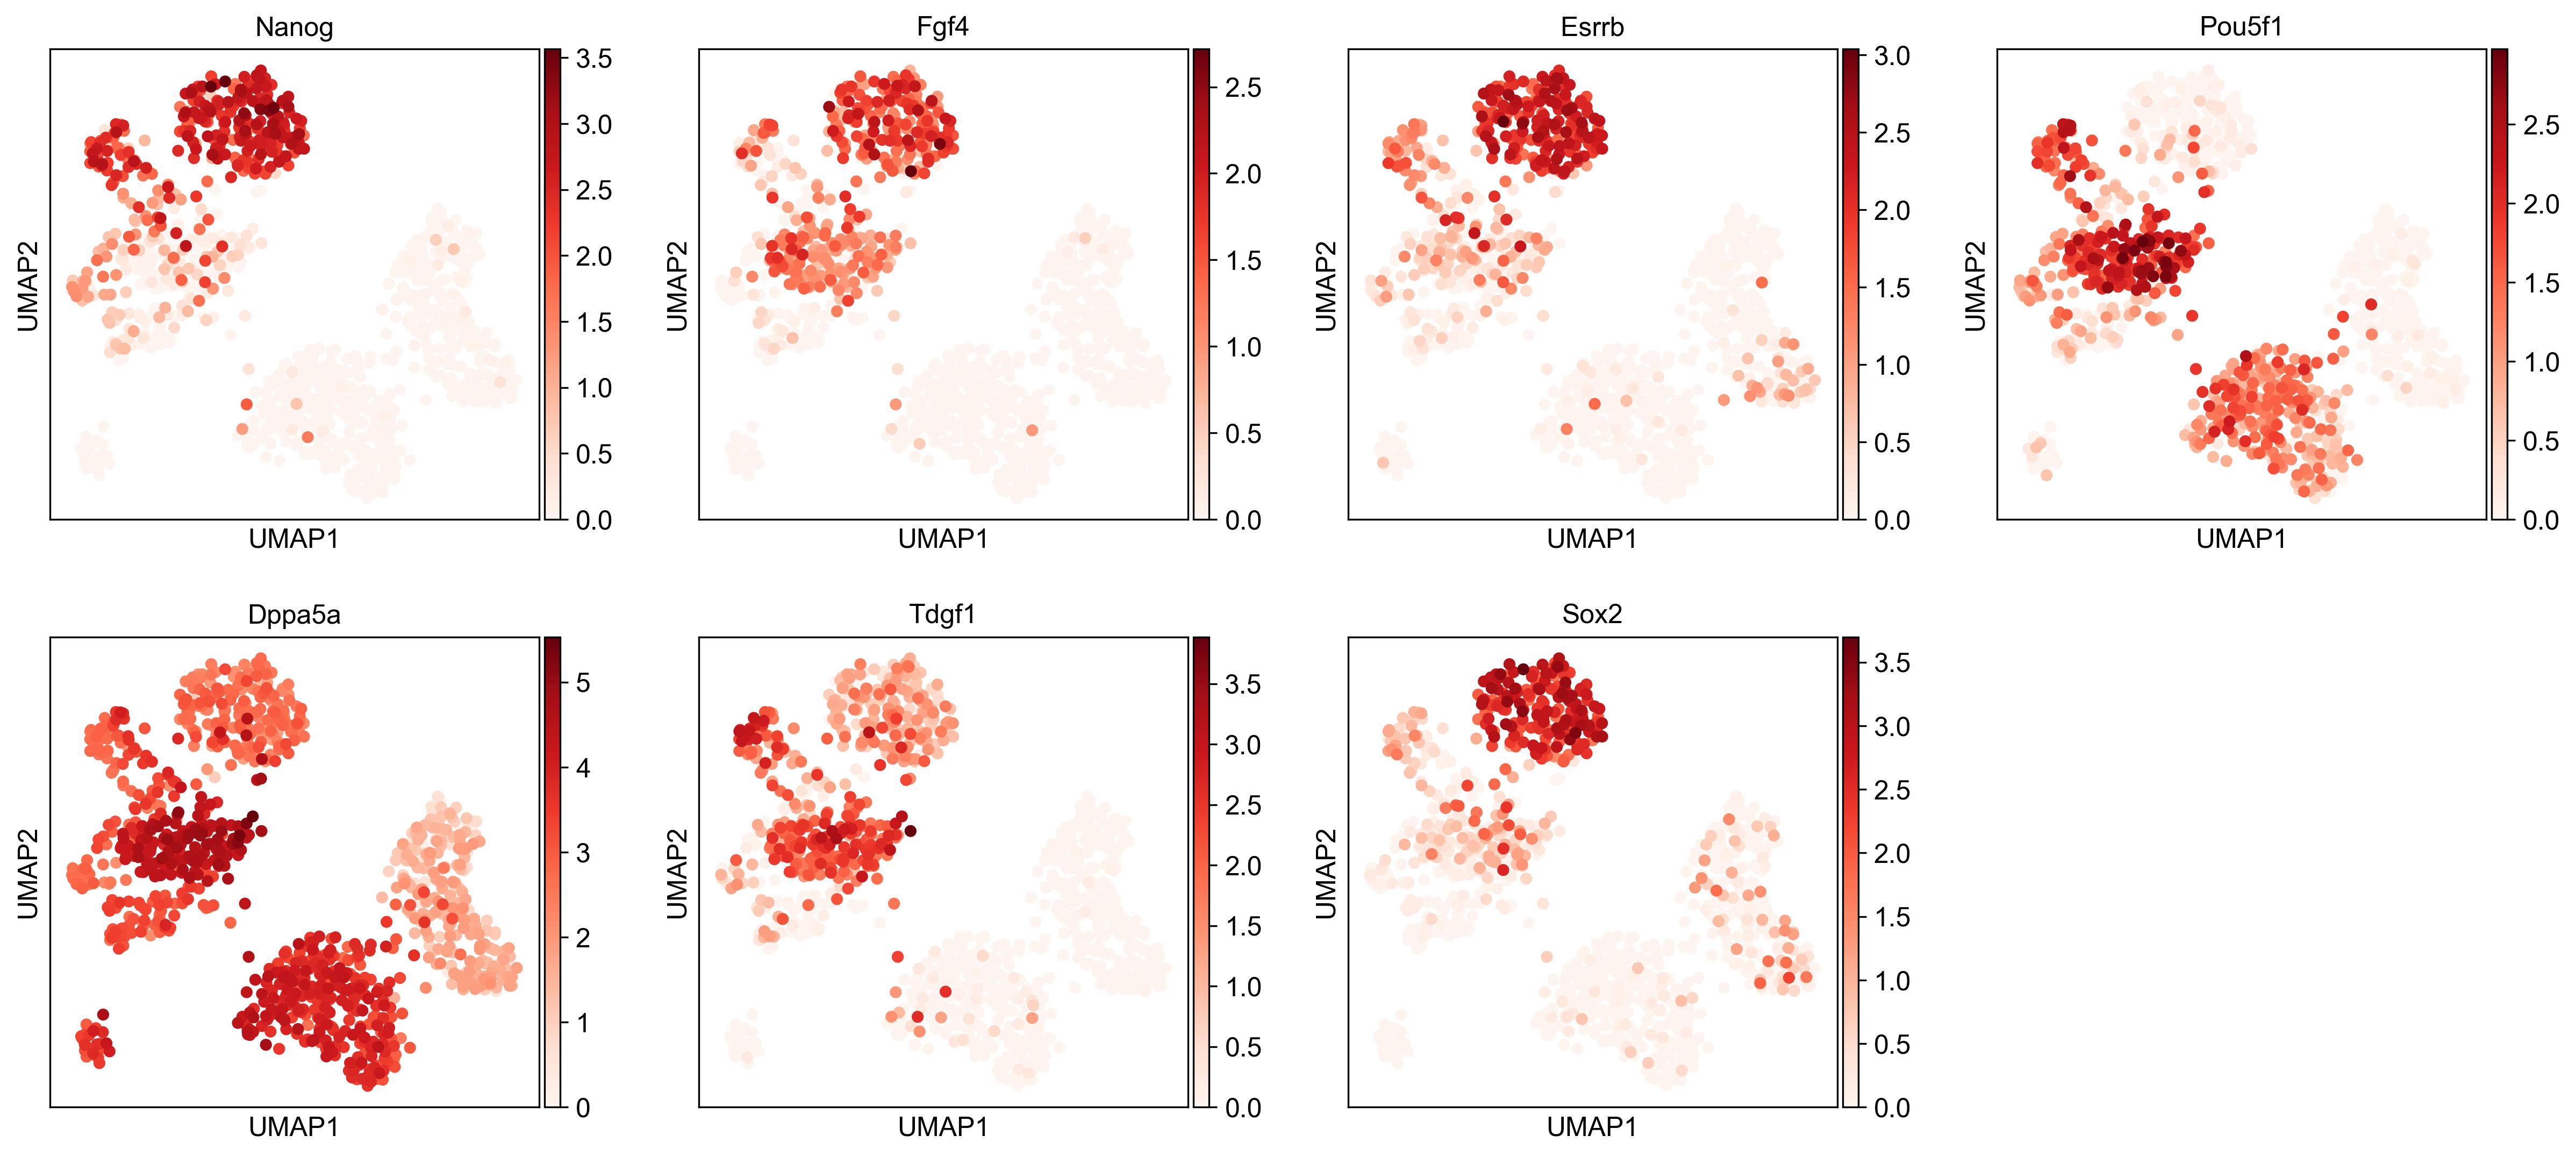

In [15]:
sc.pl.umap(adata, color=['Nanog', 'Fgf4', 'Esrrb', 'Pou5f1', 'Dppa5a', 'Tdgf1', 'Sox2'], legend_loc='on data', color_map=mpl.cm.Reds)

**UMAPs with TE markers**

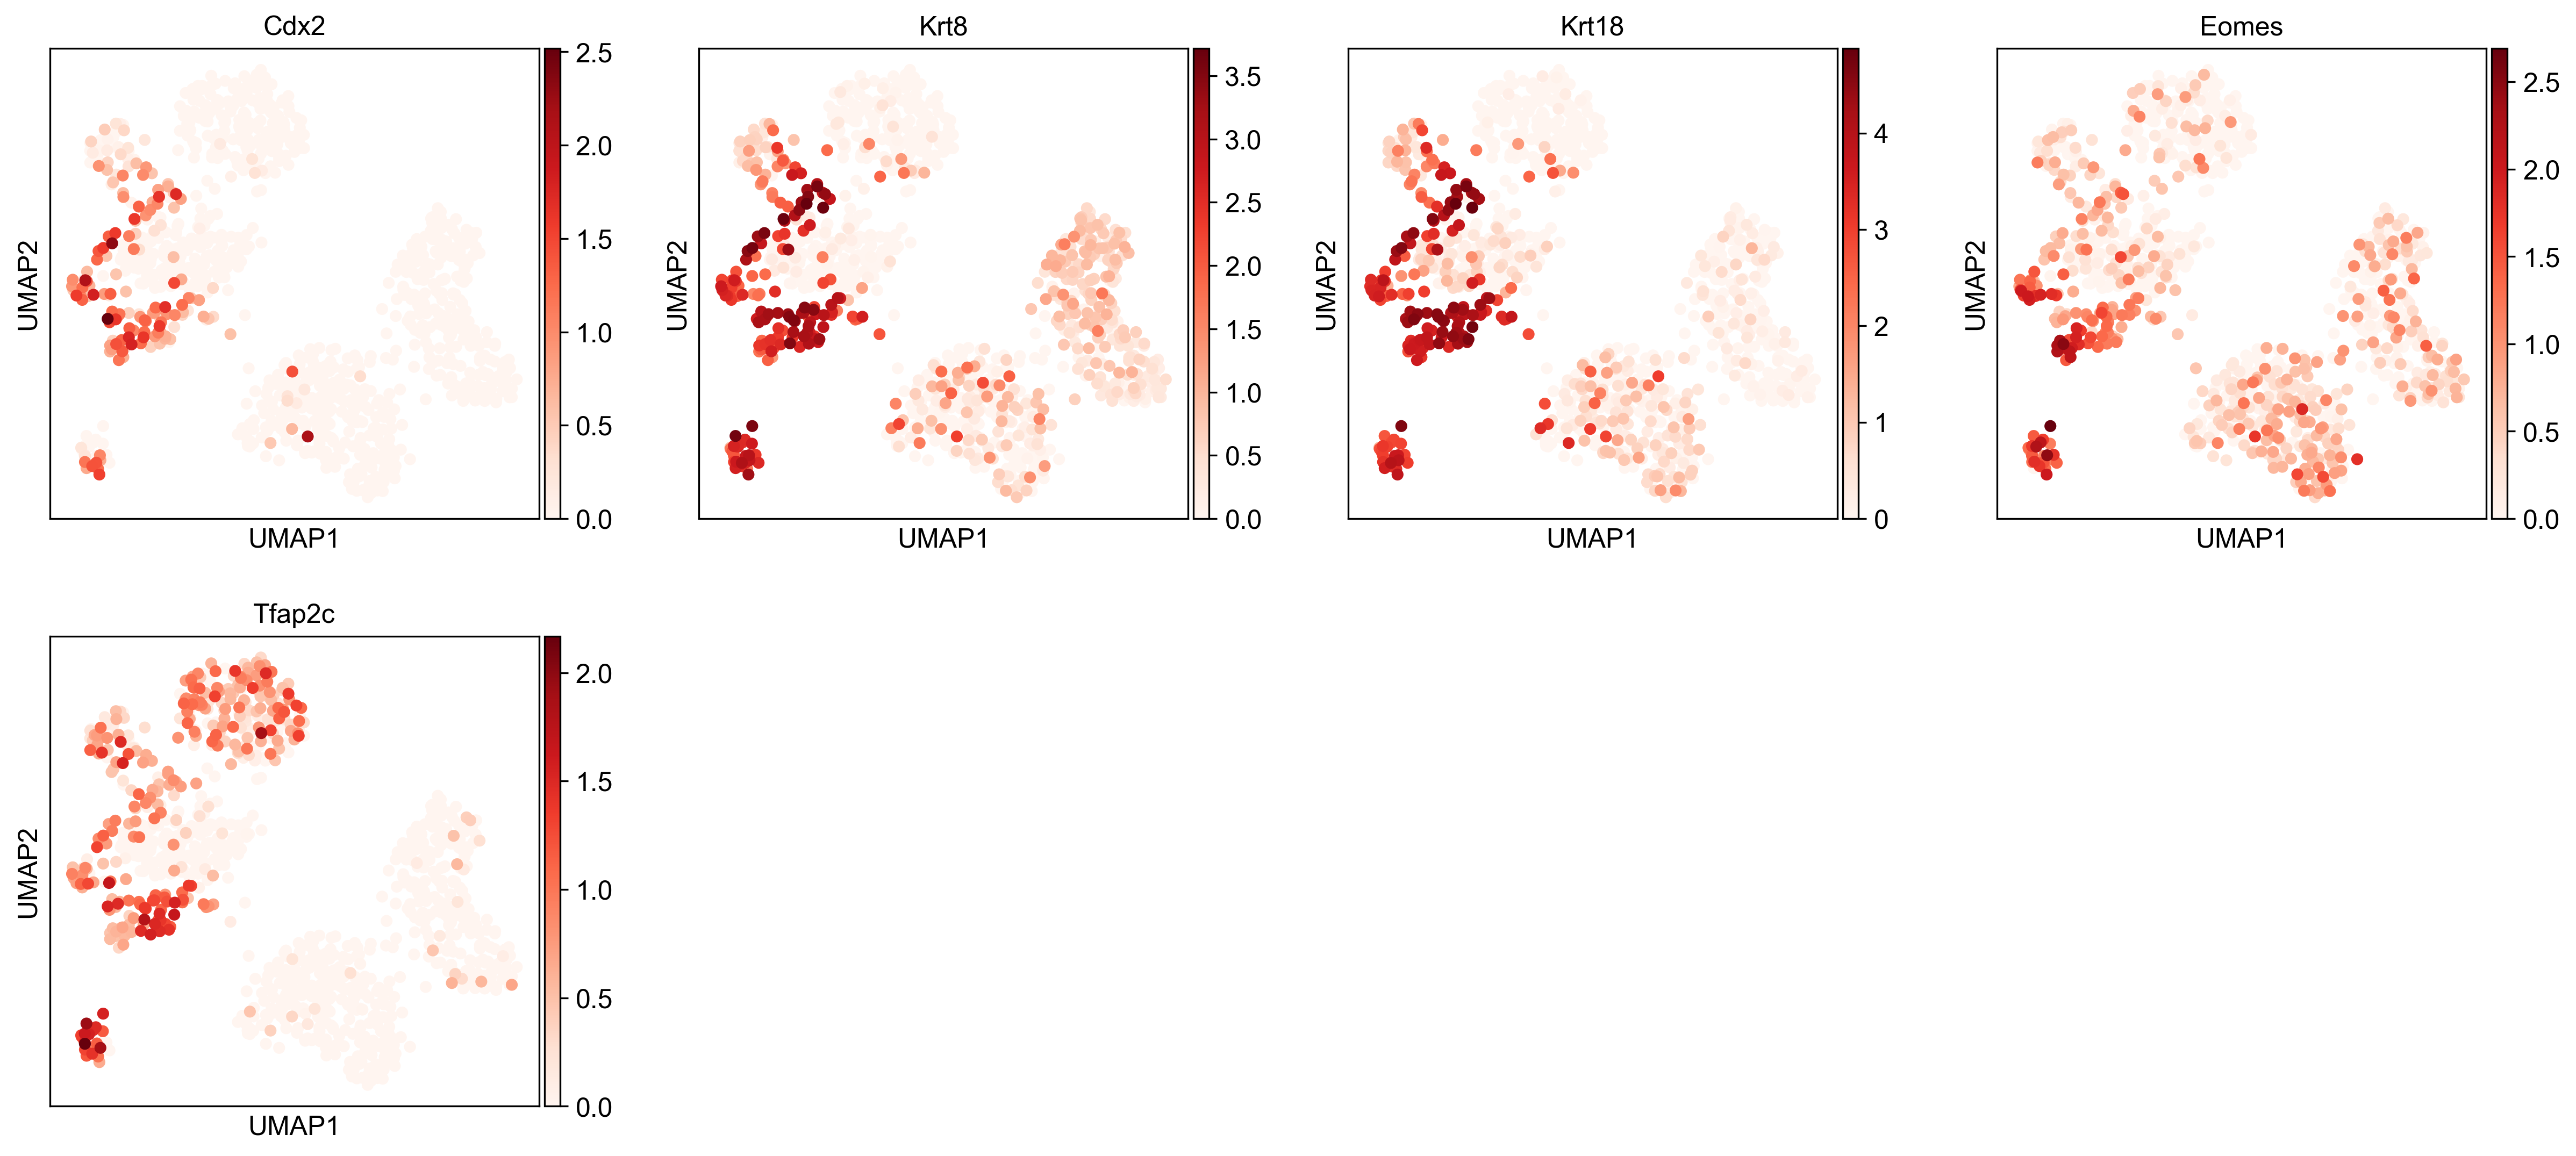

In [16]:
sc.pl.umap(adata, color=['Cdx2', 'Krt8', 'Krt18', 'Eomes', 'Tfap2c'], legend_loc='on data', color_map=mpl.cm.Reds)

**UMAPs with Lefty1 and Lefty2**

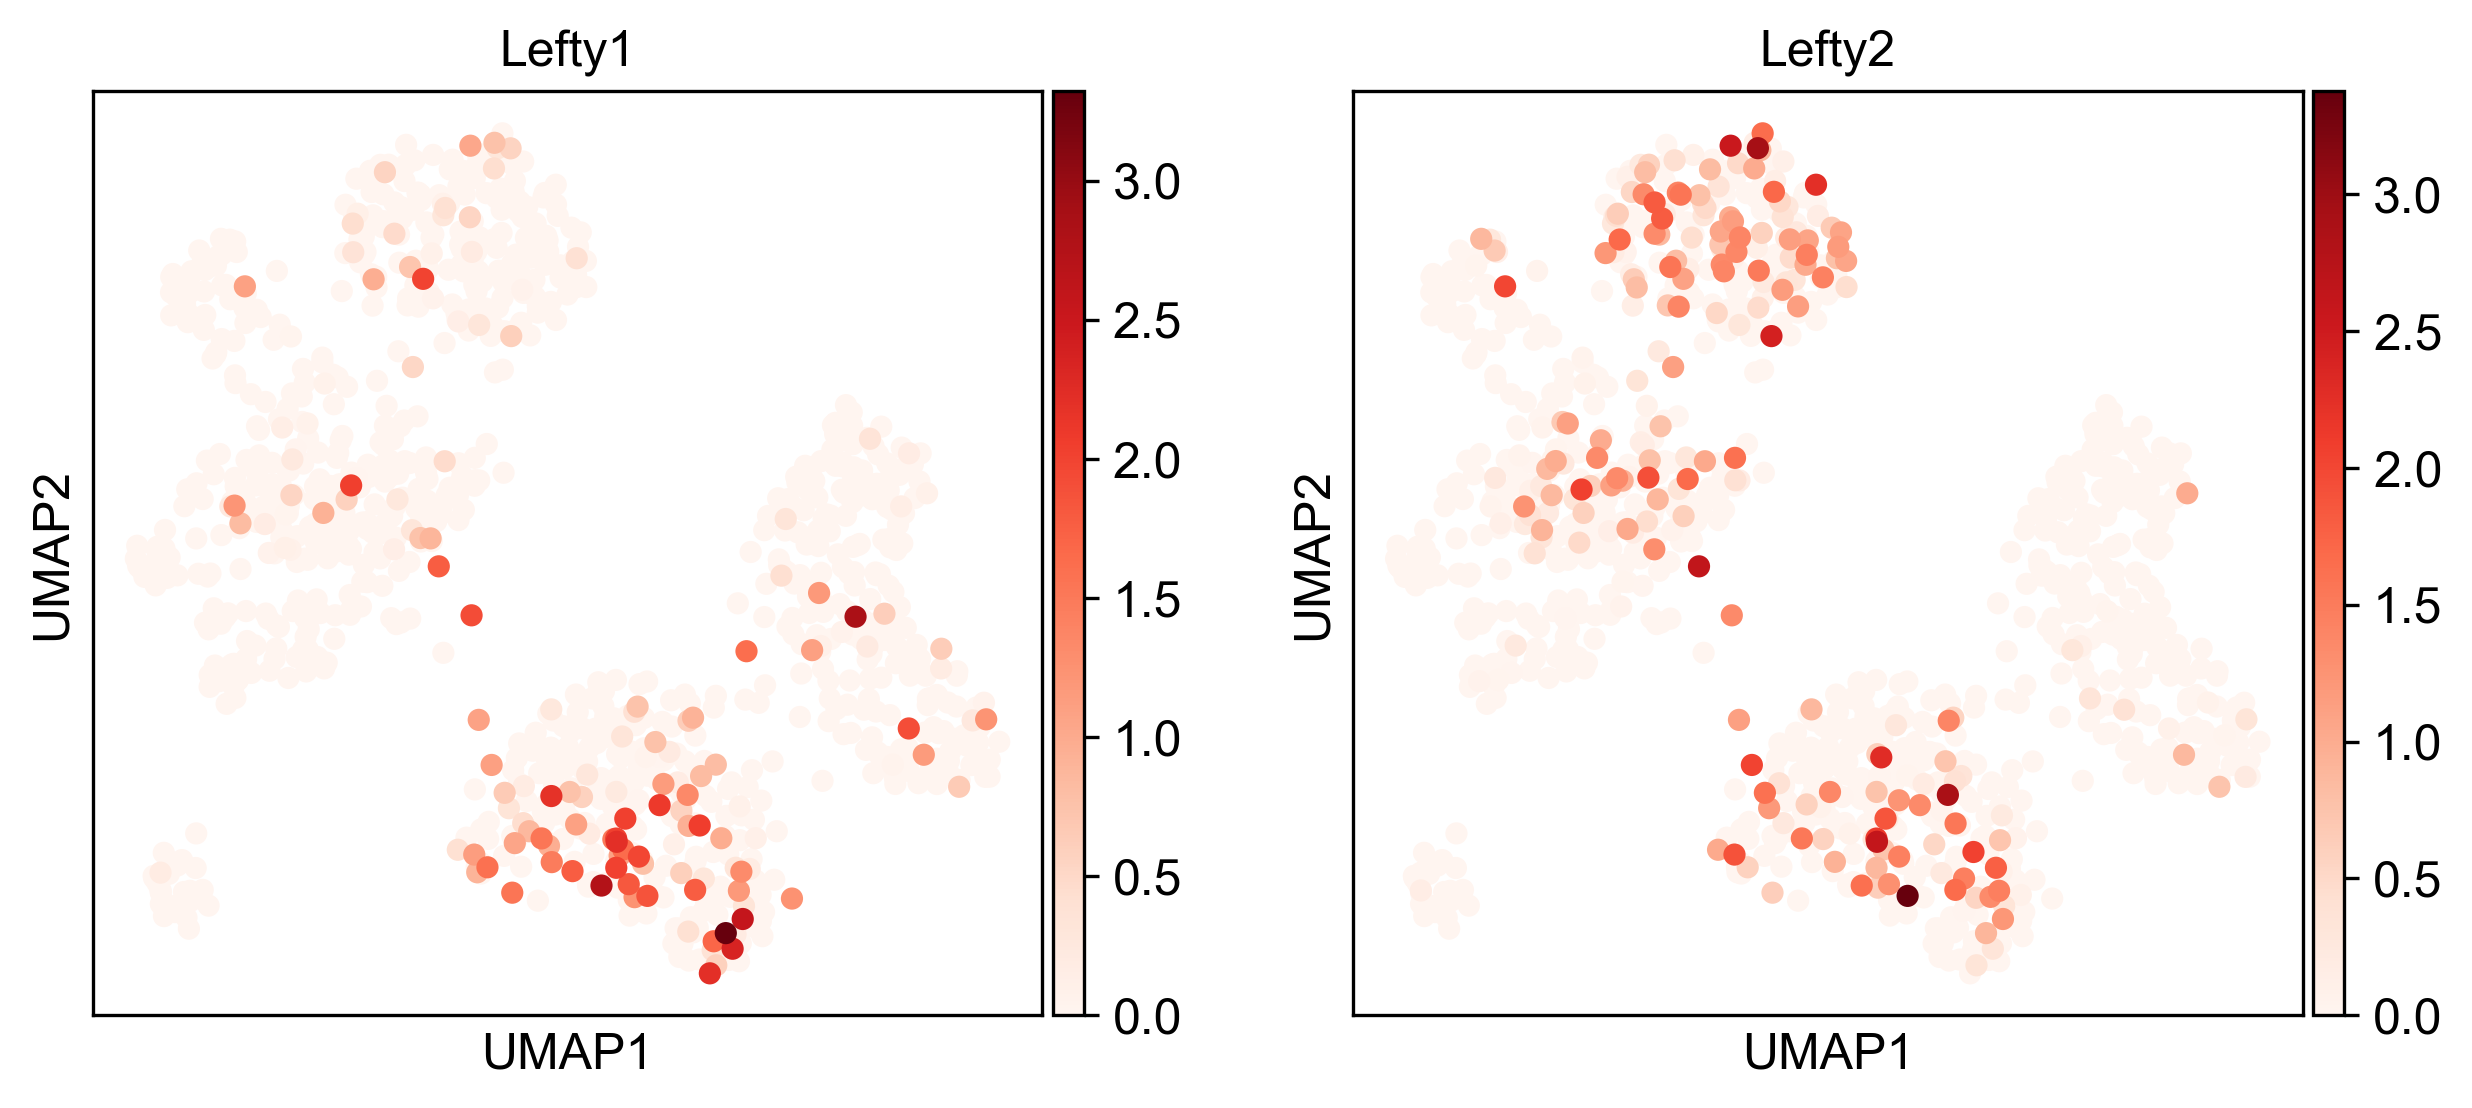

In [17]:
sc.pl.umap(adata, color=['Lefty1', 'Lefty2'], legend_loc='on data', color_map=mpl.cm.Reds)

**Add cell types**

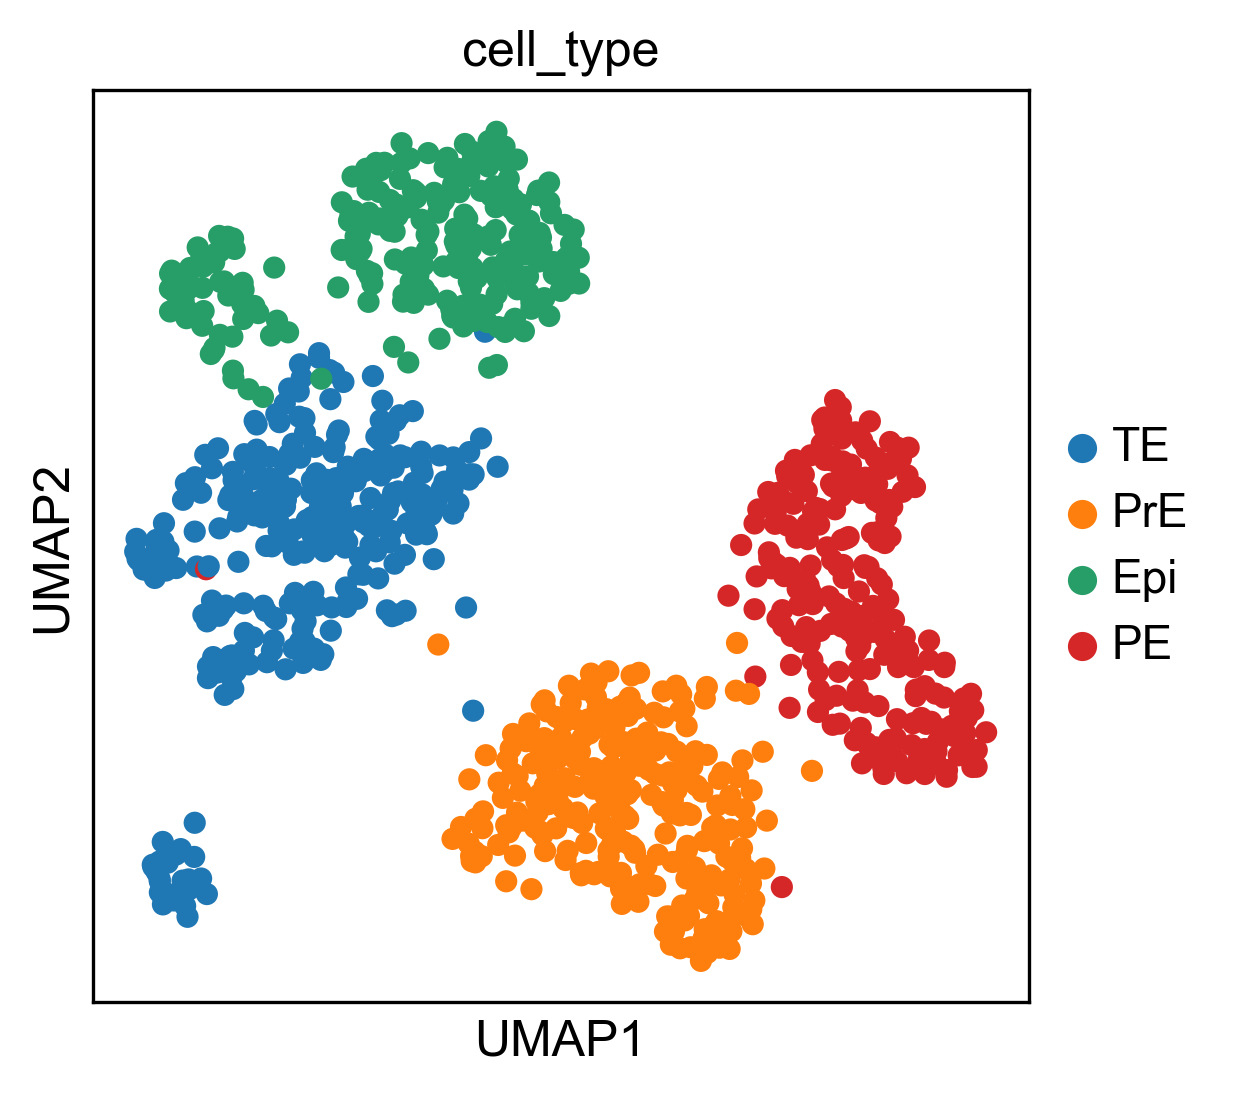

In [18]:
adata.obs['cell_type'] = adata.obs['louvain']

new_cluster_names = ['TE', 'PrE', 'Epi', 'PE']
adata.rename_categories("cell_type", new_cluster_names)

sc.pl.umap(adata, color=['cell_type'])

#adata.write('Objects/object_analyse_vrij.h5ad')

## **DEG between EB and embryos for Epi**

**Sort data**

In [19]:
# Take Epi cells
adata_Vrij_epi = adata[adata.obs['cell_type'] == 'Epi']
adata_Vrij_epi = adata_Vrij_epi[adata_Vrij_epi.obs['dataset'] == '7_Vrij']
print(adata_Vrij_epi)
adata_embr_epi = adata[adata.obs['cell_type'] == 'Epi']
adata_embr_epi = adata_embr_epi[adata_embr_epi.obs['dataset'] != '7_Vrij']
print(adata_embr_epi)

# Add metada
adata_Vrij_epi.obs['model'] = adata_Vrij_epi.n_obs * ['EB']
adata_embr_epi.obs['model'] = adata_embr_epi.n_obs * ['Embryo']

# Concatenate the 2 models
adata_Vrij_embr_epi = ad.concat([adata_Vrij_epi, adata_embr_epi], join='outer')

View of AnnData object with n_obs × n_vars = 182 × 35286
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 64 × 35286
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


C:\Users\learogue\AppData\Local\Temp\ipykernel_9948\3815231133.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_Vrij_epi.obs['model'] = adata_Vrij_epi.n_obs * ['EB']
C:\Users\learogue\AppData\Local\Temp\ipykernel_9948\3815231133.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_embr_epi.obs['model'] = adata_embr_epi.n_obs * ['Embryo']


**Rank genes for DEG analysis**

In [20]:
sc.tl.rank_genes_groups(adata_Vrij_embr_epi, 'model')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [21]:
df = sc.get.rank_genes_groups_df(adata_Vrij_embr_epi, group="EB")

In [22]:
df = df.sort_values('logfoldchanges', ascending=False)

**Remove not known genes**

In [23]:
df_Epi_ssGm = df[~df['names'].str.startswith('Gm')]

**Remove sexual genes**

In [24]:
l_genes_XY = []
with open('DEG/gene_chrX_chrY.tab', 'r') as f:
    for lig in f:
        l_genes_XY.append(lig.rstrip())

In [25]:
df_Epi_ssGmXY = df_Epi_ssGm[~df_Epi_ssGm['names'].isin(l_genes_XY)]
print(df_Epi_ssGmXY)
#df_Epi_ssGmXY.to_csv('DEG/df/df_EB_vs_embryos_Epi_sansGmXY.tab', sep = '\t')

               names     scores  logfoldchanges         pvals     pvals_adj
676           Crabp1  10.044069       28.450584  3.802760e-19  1.456940e-17
327           Pimreg  14.227222       28.059061  2.553248e-31  2.746765e-29
1092            Penk   7.908410       27.490099  2.488314e-13  5.005853e-12
552            Prdm5  11.030207       27.478821  5.750535e-22  2.907068e-20
1803           Hmgn3   5.964632       26.872017  1.260111e-08  1.358932e-07
...              ...        ...             ...           ...           ...
34253  9830004L10Rik  -7.469837      -27.416294  3.020482e-10  4.091390e-09
32909        Tacstd2  -5.022074      -27.629501  4.474659e-06  3.222302e-05
34850          Mrnip -10.186796      -27.736258  6.054035e-15  1.467189e-13
33285           Cdx2  -5.530508      -27.878700  6.554786e-07  5.425573e-06
32131       BC051665  -4.244756      -29.027967  7.328301e-05  4.185601e-04

[20937 rows x 5 columns]


**Filtering significative genes**

In [26]:
filtered_df = df_Epi_ssGmXY[df_Epi_ssGmXY['pvals_adj'] < 0.05]
print(filtered_df)
up = filtered_df[filtered_df['logfoldchanges']>=2]
print(up)
down = filtered_df[filtered_df['logfoldchanges']<=-2]
print(down)
#filtered_df.to_csv('df_EB_vs_embryos_Epi_sansGm.tab', sep = '\t')
#up.to_csv('DEG/df/df_EB_vs_embryos_Epi_sansGmXY_upreg.tab', sep = '\t')
#down.to_csv('DEG/df/df_EB_vs_embryos_Epi_sansGmXY_downregreg.tab', sep = '\t')

               names     scores  logfoldchanges         pvals     pvals_adj
676           Crabp1  10.044069       28.450584  3.802760e-19  1.456940e-17
327           Pimreg  14.227222       28.059061  2.553248e-31  2.746765e-29
1092            Penk   7.908410       27.490099  2.488314e-13  5.005853e-12
552            Prdm5  11.030207       27.478821  5.750535e-22  2.907068e-20
1803           Hmgn3   5.964632       26.872017  1.260111e-08  1.358932e-07
...              ...        ...             ...           ...           ...
34253  9830004L10Rik  -7.469837      -27.416294  3.020482e-10  4.091390e-09
32909        Tacstd2  -5.022074      -27.629501  4.474659e-06  3.222302e-05
34850          Mrnip -10.186796      -27.736258  6.054035e-15  1.467189e-13
33285           Cdx2  -5.530508      -27.878700  6.554786e-07  5.425573e-06
32131       BC051665  -4.244756      -29.027967  7.328301e-05  4.185601e-04

[8185 rows x 5 columns]
        names     scores  logfoldchanges         pvals     pval

**Volcano plot**

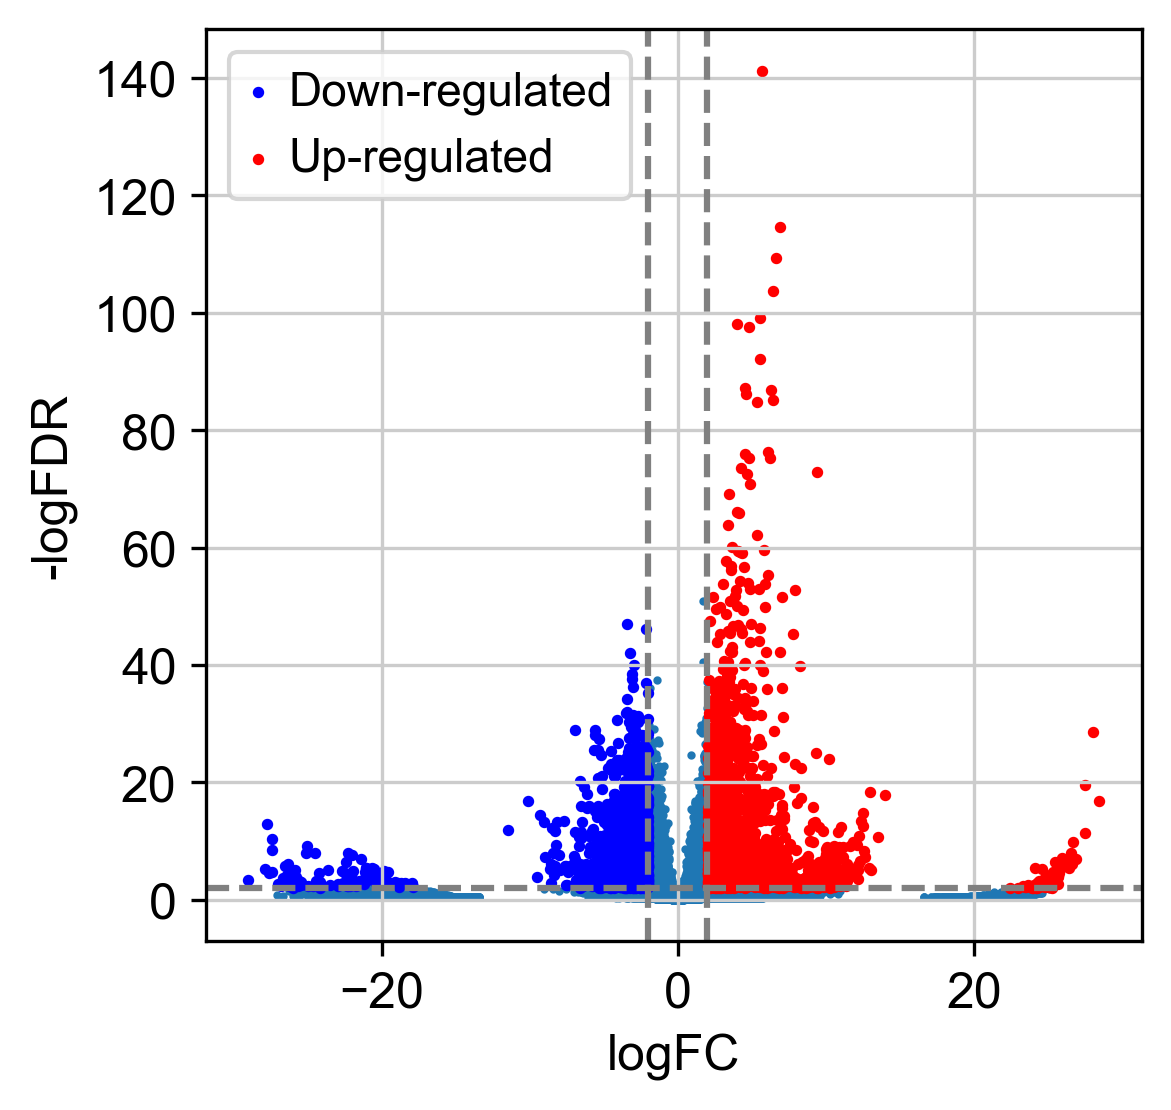

In [27]:
plt.scatter(x=df_Epi_ssGmXY['logfoldchanges'],y=df_Epi_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df_Epi_ssGmXY[(df_Epi_ssGmXY['logfoldchanges']<=-2)&(df_Epi_ssGmXY['pvals_adj']<=0.01)]
up = df_Epi_ssGmXY[(df_Epi_ssGmXY['logfoldchanges']>=2)&(df_Epi_ssGmXY['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **Comparison between PrE EB and PrE embryos**

**Take PrE cells and rank genes**

In [28]:
# PrE
adata_Vrij_pre = adata[adata.obs['cell_type'] == 'PrE']
adata_Vrij_pre = adata_Vrij_pre[adata_Vrij_pre.obs['dataset'] == '7_Vrij']
print(adata_Vrij_pre)
adata_embr_pre = adata[adata.obs['cell_type'] == 'PrE']
adata_embr_pre = adata_embr_pre[adata_embr_pre.obs['dataset'] != '7_Vrij']
print(adata_embr_pre)
adata_Vrij_pre.obs['model'] = adata_Vrij_pre.n_obs * ['EB']
adata_embr_pre.obs['model'] = adata_embr_pre.n_obs * ['Embryo']

adata_Vrij_embr_pre = ad.concat([adata_Vrij_pre, adata_embr_pre], join='outer')

#rank genes
sc.tl.rank_genes_groups(adata_Vrij_embr_pre, 'model')

View of AnnData object with n_obs × n_vars = 2 × 35286
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
View of AnnData object with n_obs × n_vars = 271 × 35286
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'n_genes', 'louvain', 'cell_type'
    var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'louvain', 'umap', 'dataset_colors', 'louvain_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
ranking genes


C:\Users\learogue\AppData\Local\Temp\ipykernel_9948\2432106519.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_Vrij_pre.obs['model'] = adata_Vrij_pre.n_obs * ['EB']
C:\Users\learogue\AppData\Local\Temp\ipykernel_9948\2432106519.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_embr_pre.obs['model'] = adata_embr_pre.n_obs * ['Embryo']


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


**Filter genes**

In [29]:
df = sc.get.rank_genes_groups_df(adata_Vrij_embr_pre, group="EB")

# Sort by logfoldchanges
df = df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE.tab', sep = '\t')

# Filtering Gm
df_PrE_ssGm = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm.tab', sep = '\t')
df_PrE_ssGmXY = df_PrE_ssGm[~df_PrE_ssGm['names'].isin(l_genes_XY)]
#df_PrE_ssGmXY.to_csv('DEG/df/df_EB_vs_embryos_PrE_sansGmXY.tab', sep = '\t')

# Filter significative data
filtered_df = df_PrE_ssGm[df_PrE_ssGm['pvals_adj'] < 0.05]
up = filtered_df[filtered_df['logfoldchanges']>=2]
print(up)
down = filtered_df[filtered_df['logfoldchanges']<=-2]
print(down)

#up.to_csv('DEG/df/df_EB_vs_embryos_PrE_sansGmXY_upreg.tab', sep = '\t')
#down.to_csv('DEG/df/df_EB_vs_embryos_PrE_sansGmXY_downregreg.tab', sep = '\t')

             names      scores  logfoldchanges          pvals      pvals_adj
0              Clu  377.094971        8.590637   2.975033e-09   4.673955e-08
2          Mir6236  156.677383        5.662289   6.671714e-24   4.181494e-22
4         Eef2-ps2   95.502151        5.024681   4.586550e-12   9.610510e-11
13           Mbnl2   48.228886        4.737063   8.906269e-04   6.205897e-03
12            Ltbr   48.619480        4.349913   3.710190e-04   2.826987e-03
5         Slc25a30   84.342567        4.264482  3.424568e-106  1.510491e-102
7             Nxf7   62.815128        4.263765   6.960525e-21   3.310096e-19
6             Dmtn   69.165581        4.248529   2.595020e-14   6.752793e-13
19          Tmsb4x   35.990635        3.692986   1.504548e-12   3.297484e-11
8           Rnf19a   60.359974        3.664347   2.013487e-54   1.014970e-51
27           Lima1   31.840282        3.658407   1.541675e-03   9.994405e-03
30      Eif5al3-ps   29.469269        3.597061   1.256944e-03   8.385804e-03

**Volcano plot**

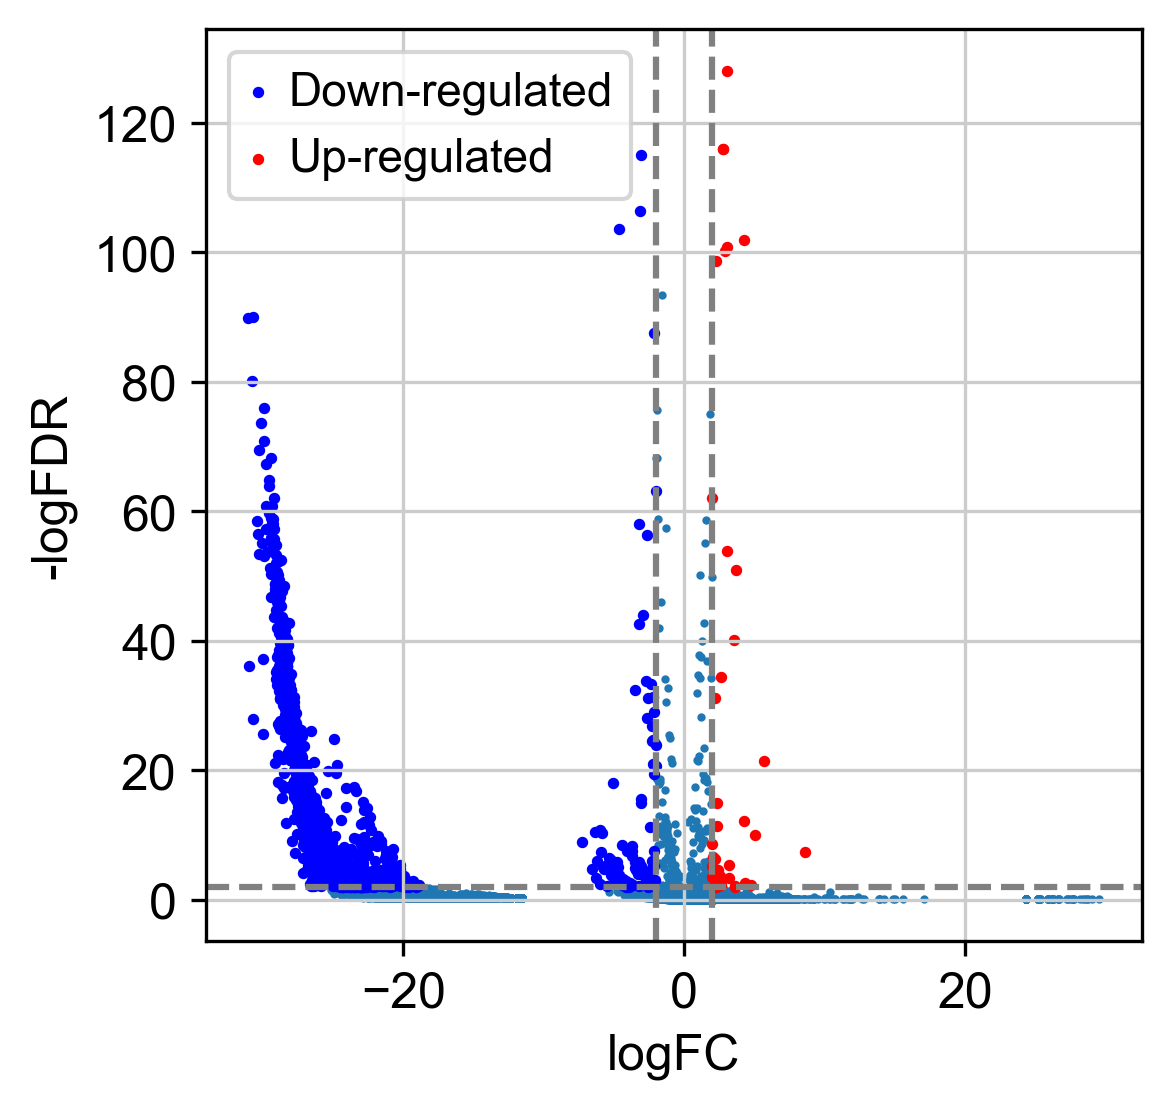

In [30]:
plt.scatter(x=df_PrE_ssGmXY['logfoldchanges'],y=df_PrE_ssGmXY['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df_PrE_ssGmXY[(df_PrE_ssGmXY['logfoldchanges']<=-2)&(df_PrE_ssGmXY['pvals_adj']<=0.01)]
up = df_PrE_ssGmXY[(df_PrE_ssGmXY['logfoldchanges']>=2)&(df_PrE_ssGmXY['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **DEG between Lefty1+ cells from PrE between EB and embryos**

**Filtering cells and genes**

In [31]:
# DEG Lefty1 EB/embr
adata_Vrij_pre_lefty = adata_Vrij_pre[:, 'Lefty1']
print(adata_Vrij_pre_lefty.obs)
adata_embr_pre_lefty  = adata_embr_pre[:, 'Lefty1']

adata_embr_vrij_pre_lefty = ad.concat([adata_Vrij_pre_lefty, adata_embr_pre_lefty], join='outer')

#rank genes
sc.tl.rank_genes_groups(adata_embr_vrij_pre_lefty, 'model')
df = sc.get.rank_genes_groups_df(adata_embr_vrij_pre_lefty, group="EB")

# Sort by logfoldchanges
df= df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE_lefty1.tab', sep = '\t')
df = df[~df['names'].isin(l_genes_XY)]

# Filter
df = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm_Lefty1.tab', sep = '\t')

# Filter significative data to add gene names on volcano plot
filtered_df = df[df['pvals_adj'] < 0.05]
print(filtered_df.head(15))
print(filtered_df.tail(15))

            n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
SRR8883284               6205      126538.0          13379.0      10.573109   
SRR8883520               7654      231121.0          21138.0       9.145859   

           dataset  n_genes louvain cell_type model  
SRR8883284  7_Vrij     6205       1       PrE    EB  
SRR8883520  7_Vrij     7654       1       PrE    EB  
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
             names      scores  logfoldchanges          pvals      pvals_adj
0              Clu  377.094971        8.590637   2.975033e-09   4.673955e-08
2          Mir6236  156.677383        5.662289   6.671714e-24 

**Volcano plot**

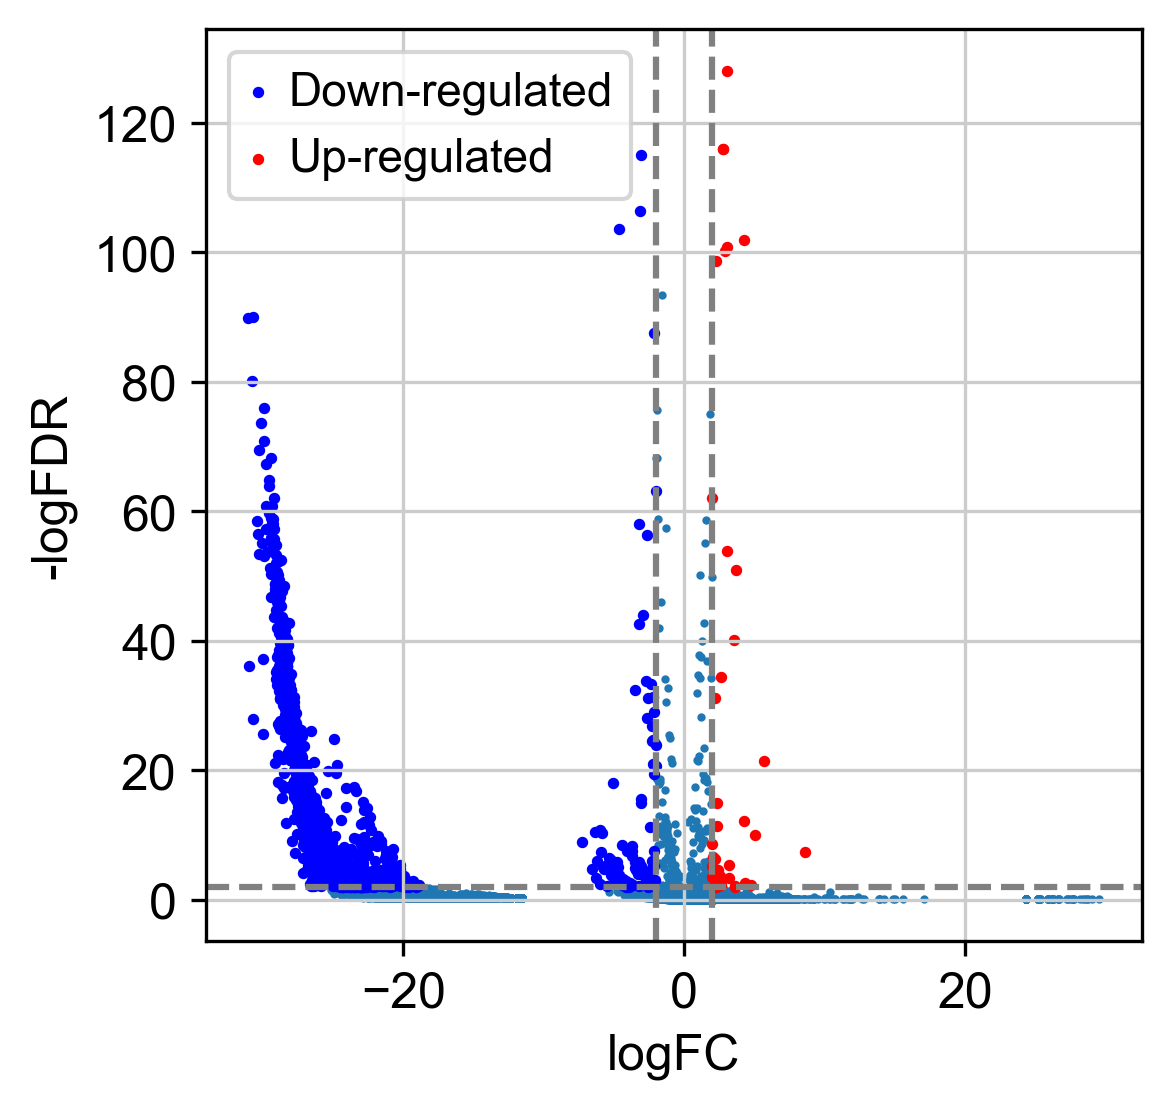

In [32]:
plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

## **DEG between Lefty1+ cells from PrE between EB and embryos**

**Filter cells and genes**

In [33]:
adata_Vrij_pre_lefty = adata_Vrij_pre[:, 'Lefty2']
adata_embr_pre_lefty  = adata_embr_pre[:, 'Lefty2']
adata_embr_vrij_pre_lefty = ad.concat([adata_Vrij_pre_lefty, adata_embr_pre_lefty], join='outer')

#rank genes
sc.tl.rank_genes_groups(adata_embr_vrij_pre_lefty, 'model')

df = sc.get.rank_genes_groups_df(adata_embr_vrij_pre_lefty, group="EB")

# Sort by logfoldchanges
df= df.sort_values('logfoldchanges', ascending=False)
#df.to_csv('DEG/df_EB_vs_embryos_PrE_lefty2.tab', sep = '\t')"""

# Filter
df = df[~df['names'].str.startswith('Gm')]
#df.to_csv('DEG/df_EB_vs_embryos_PrE_sansGm_Lefty2.tab', sep = '\t')

# Filter significative data to add gene names on volcano plot
filtered_df = df[df['pvals_adj'] < 0.05]
print(filtered_df.head(15))
print(filtered_df.tail(15))

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
          names      scores  logfoldchanges          pvals      pvals_adj
0           Clu  377.094971        8.590637   2.975033e-09   4.673955e-08
2       Mir6236  156.677383        5.662289   6.671714e-24   4.181494e-22
4      Eef2-ps2   95.502151        5.024681   4.586550e-12   9.610510e-11
13        Mbnl2   48.228886        4.737063   8.906269e-04   6.205897e-03
12         Ltbr   48.619480        4.349913   3.710190e-04   2.826987e-03
5      Slc25a30   84.342567        4.264482  3.424568e-106  1.510491e-102
7          Nxf7   62.815128        4.263765   6.960525e-21   3.310096e-19
6          Dmtn   69.165

**Volcano plot**

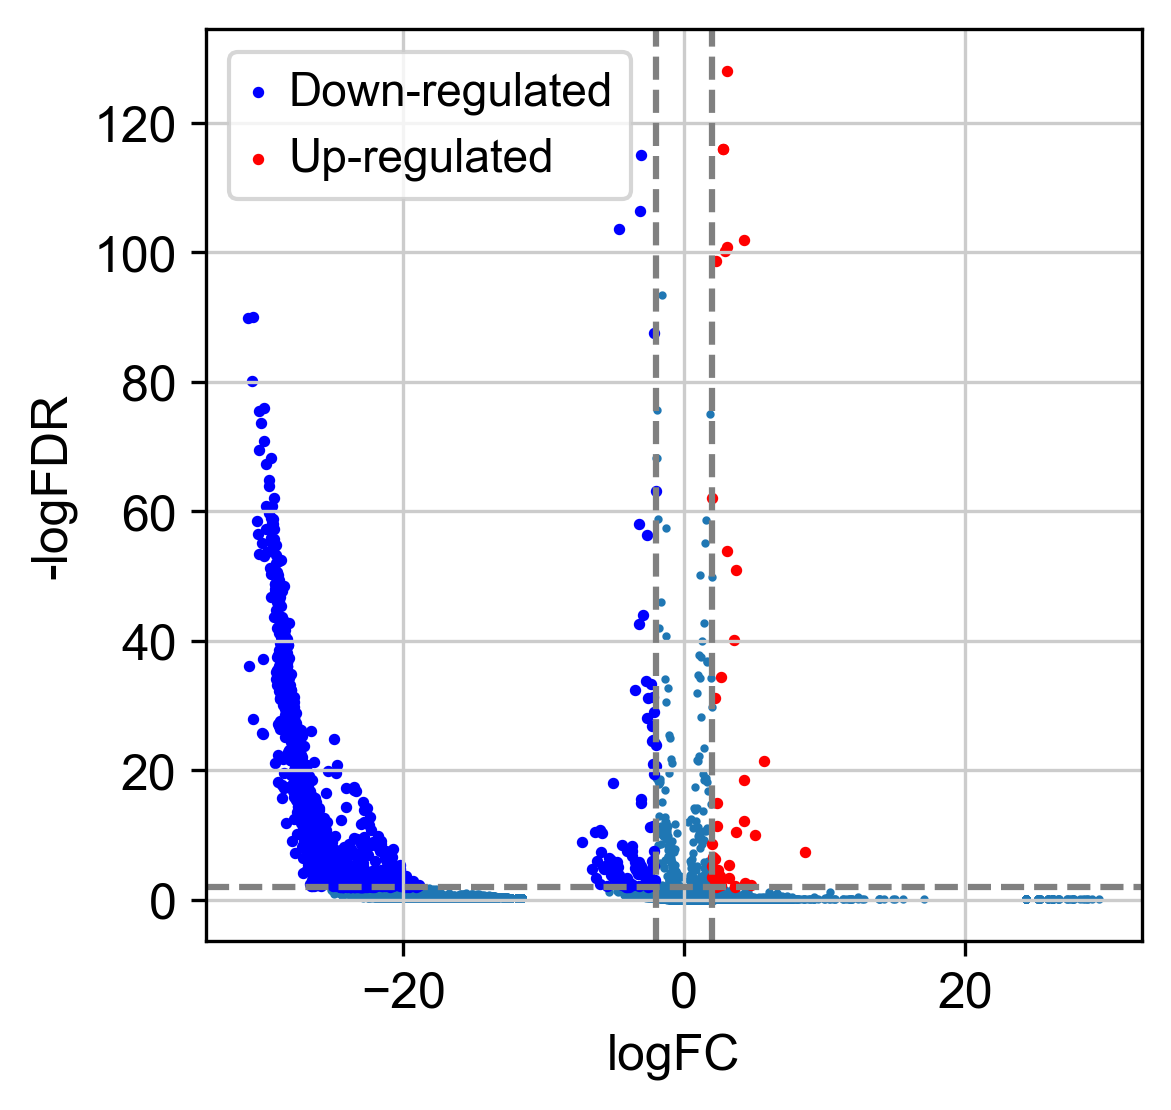

In [34]:
plt.scatter(x=df['logfoldchanges'],y=df['pvals_adj'].apply(lambda x:-np.log10(x)),s=1)

# highlight down- or up- regulated genes
down = df[(df['logfoldchanges']<=-2)&(df['pvals_adj']<=0.01)]
up = df[(df['logfoldchanges']>=2)&(df['pvals_adj']<=0.01)]

plt.scatter(x=down['logfoldchanges'],y=down['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
plt.scatter(x=up['logfoldchanges'],y=up['pvals_adj'].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")

plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()